In [1]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from os import path

In [2]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega

In [4]:
def load_Qfunction(fileName):
    Qload = Qfunction(env)
    Qload.load_state_dict(torch.load(fileName))
    Qload.eval()
    return Qload


In [5]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

fileName = 'Qfunction1906Morning.pt'

# load Q-function
Q = load_Qfunction(fileName)

Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]


In [8]:
u,theta,omega = show(Q, env, '')

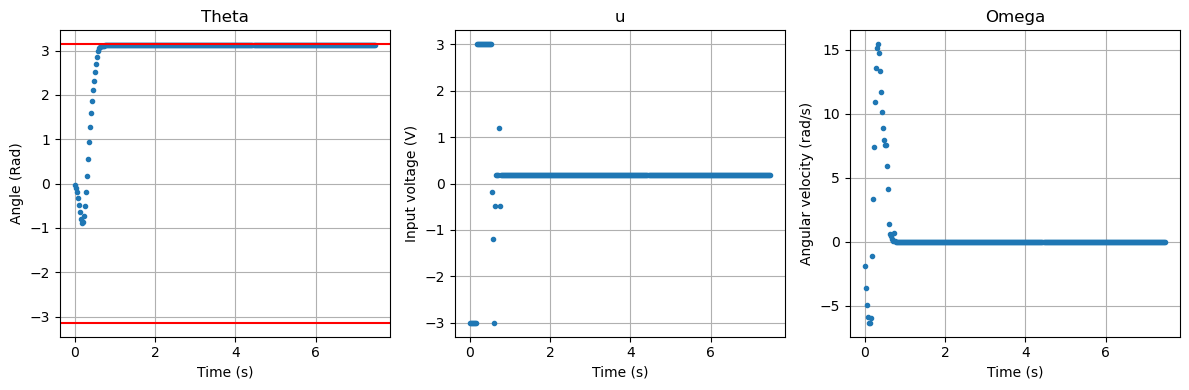

In [7]:
target_angle = np.pi # target set to be balanced on top

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot([i*env.dt for i in range(max_episode_steps)], theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (Rad)')
axs[0].axhline(y=target_angle, color='r', linestyle='-')
axs[0].axhline(y=-target_angle, color='r', linestyle='-')
axs[0].grid(True)

# Plot u
axs[1].plot([i*env.dt for i in range(max_episode_steps)], u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Input voltage (V)')
axs[1].grid(True)

# Plot omega
axs[2].plot([i*env.dt for i in range(max_episode_steps)], omega, '.')
axs[2].set_title('Omega')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Angular velocity (rad/s)')
axs[2].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()